In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import DTD
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Especificar una seed para reproducibilidad de resultados
def set_seed(seed) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 42
set_seed(seed)

## Dataset

He elegido el Dataset que brinda la libreria de torchvision llamado 'DTD' (Describable Textures Dataset).

Este dataset contiene una coleccion de 5640 imagenes clasificadas en 47 categorias. La clasificacion tiene en cuenta las diferentes texturas que se pueden apreciar en las imagenes. 

El tamano en pixeles de cada imagen varia entre 300x300 y 640x640, lo que hace imprescindible su normalizacion. 

El dataset esta dividido a partes iguales entre train/validation/test. Mi intencion es utilizar una particion menos igualitaria, utilizando el 60%/15%/25%, ya que creo que es una particion que me va a ayudar a conseguir mejores resultados. 
El hecho de que el test set sea algo mayor que el validation set es para intentar evitar bias a la hora de calcular la performance del modelo.

Usare pytorch lightning para hacer el entrenamiento de forma mas automatica

In [3]:
subscaling = 128
transform = transforms.Compose([
    transforms.Resize((subscaling, subscaling)), # Redimensionar las imágenes al valor especificado en subscaling
    transforms.ToTensor() # Convertir las imágenes a tensores y normalizar los valores de los pixeles a [0, 1]
])

# Descargar y cargar el dataset
dataset = DTD(root='data', download=True, transform=transform)

# Dividir el dataset en train, validation y test
total_samples = len(dataset)
n_train_samples = int(0.55 * total_samples)
n_val_samples = int(0.15 * total_samples)
n_test_samples = total_samples - n_train_samples - n_val_samples
train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])


# Crear DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Plotear 10 imagenes con su respectivo label

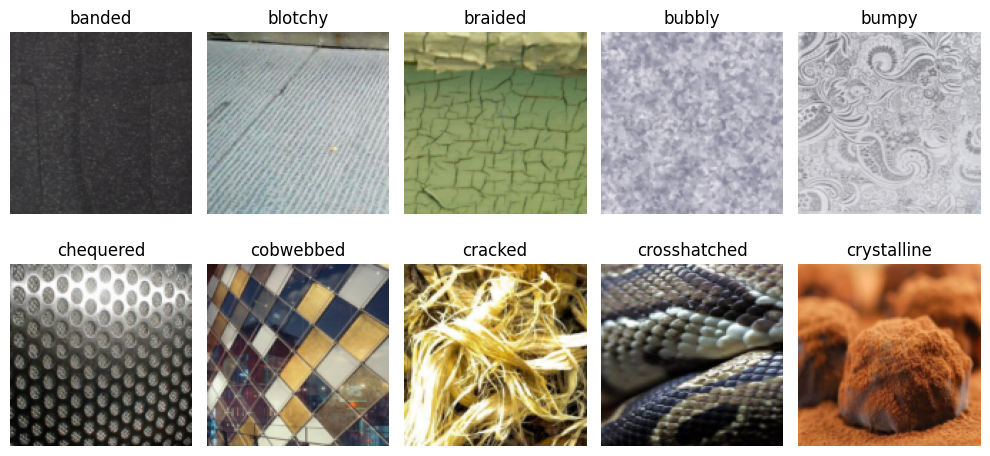

In [4]:
fig = plt.figure(figsize=(10, 5))
im1 = train_dataset[0][0]

for i in range(10):
    im1 = train_dataset[i][0]
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(im1.permute(1, 2, 0))
    ax.axis('off')
    class_name = dataset.classes[i]
    ax.title.set_text(class_name)

plt.tight_layout()
plt.show()

### Definicion del modelo base

Definimos un modelo base basado en pytorch lightning. Esto me ahorrara tener que definir los diferentes metodos necesarios en el resto de modelos que testeare

In [5]:
# En pytorch lightning, los modelos tienen una serie de metodos que hay que definir.
# Definiendolos el entrenamiento sera automatico

class BaseModel(pl.LightningModule):
    def __init__(
        self,
        backbone: torch.nn.Sequential = None,
        loss_fn: torch.nn.Module = None,
        optimizer: torch.optim.Optimizer = None,
        optimizer_args: dict = None,
        ):
        super().__init__()
            
        self.backbone = backbone
        self.optimizer = optimizer
        self.optimizer_args = optimizer_args
        self.loss = loss_fn
    
    def forward(self, x):
        return self.backbone(x)
    
    def compute_loss(self, prediction, truth):
        return self.loss(prediction, truth)
    
    def training_step(self, batch, batch_idx):
        train_loss = self.shared_step(batch, batch_idx)
        self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        val_loss = self.shared_step(batch, batch_idx)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        test_loss = self.shared_step(batch, batch_idx)
        self.log('test_loss', test_loss)
        return test_loss
    
    def shared_step(self, batch, batch_idx):
        x, truth = batch
        prediction = self(x)
        loss = self.compute_loss(prediction, truth)
        return loss
    
    def configure_optimizers(self):
        optimizer = self.optimizer(self.backbone.parameters(), **self.optimizer_args)
        return optimizer

## modelo 1, redes convolucionales

Defino un modelo bastante estandar con layers convolucionales. 
Al ser un dataset no muy grande, pongo `Dropout` layers y `weight_decay` para evitar overfitting

In [6]:
num_classes = 47
subscaling = 32 
hidden_size = subscaling // 4

backbone = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((2, 2)),

    nn.Flatten(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(256, num_classes)
)
        
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
optimizer_args = {'lr': 1e-3, 'weight_decay': 0.05, }
model = BaseModel(backbone=backbone, 
                  optimizer=optimizer, 
                  loss_fn=loss,
                  optimizer_args=optimizer_args)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
trainer_args = {
    'max_epochs': 200,
    'gpus': [0] if torch.cuda.is_available() else [],
    'callbacks': [early_stopping],
    'enable_progress_bar': True,
}



trainer = pl.Trainer(**trainer_args)
trainer.fit(model, train_dataloader, val_dataloader)

/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of the

Sanity Checking: 0it [00:00, ?it/s]

/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 22/22 [00:07<00:00,  2.83it/s, loss=3.85, v_num=35, train_loss_step=3.860, val_loss=3.850]

Metric val_loss improved. New best score: 3.850


Epoch 1: 100%|██████████| 22/22 [00:07<00:00,  2.91it/s, loss=3.84, v_num=35, train_loss_step=3.820, val_loss=3.850, train_loss_epoch=3.850]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 3.848


Epoch 2: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s, loss=3.83, v_num=35, train_loss_step=3.800, val_loss=3.840, train_loss_epoch=3.840]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 3.844


Epoch 3: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s, loss=3.8, v_num=35, train_loss_step=3.750, val_loss=3.820, train_loss_epoch=3.830] 

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 3.824


Epoch 5: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s, loss=3.77, v_num=35, train_loss_step=3.580, val_loss=3.820, train_loss_epoch=3.790]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.822


Epoch 6: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s, loss=3.77, v_num=35, train_loss_step=3.830, val_loss=3.810, train_loss_epoch=3.780]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 3.808


Epoch 15: 100%|██████████| 22/22 [00:06<00:00,  3.26it/s, loss=3.77, v_num=35, train_loss_step=3.760, val_loss=3.810, train_loss_epoch=3.770]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 3.807


Epoch 21: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=3.76, v_num=35, train_loss_step=3.710, val_loss=3.800, train_loss_epoch=3.760]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 3.802


Epoch 25: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=3.75, v_num=35, train_loss_step=3.680, val_loss=3.800, train_loss_epoch=3.770]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 3.800


Epoch 26: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s, loss=3.75, v_num=35, train_loss_step=3.670, val_loss=3.800, train_loss_epoch=3.760]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.797


Epoch 29: 100%|██████████| 22/22 [00:06<00:00,  3.24it/s, loss=3.77, v_num=35, train_loss_step=3.810, val_loss=3.790, train_loss_epoch=3.760]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 3.793


Epoch 49: 100%|██████████| 22/22 [00:07<00:00,  2.95it/s, loss=3.77, v_num=35, train_loss_step=3.960, val_loss=3.810, train_loss_epoch=3.760]

Monitored metric val_loss did not improve in the last 20 records. Best score: 3.793. Signaling Trainer to stop.


Epoch 49: 100%|██████████| 22/22 [00:07<00:00,  2.94it/s, loss=3.77, v_num=35, train_loss_step=3.960, val_loss=3.810, train_loss_epoch=3.760]


In [12]:
# Guardar el modelo entrenado
#torch.save(model.state_dict(), 'cnn_1.pth')
ckpt = torch.load('./cnn_1.pth')
model.load_state_dict(ckpt)
model
# Evaluar el modelo en el conjunto de test
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.8124420642852783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.8124420642852783}]

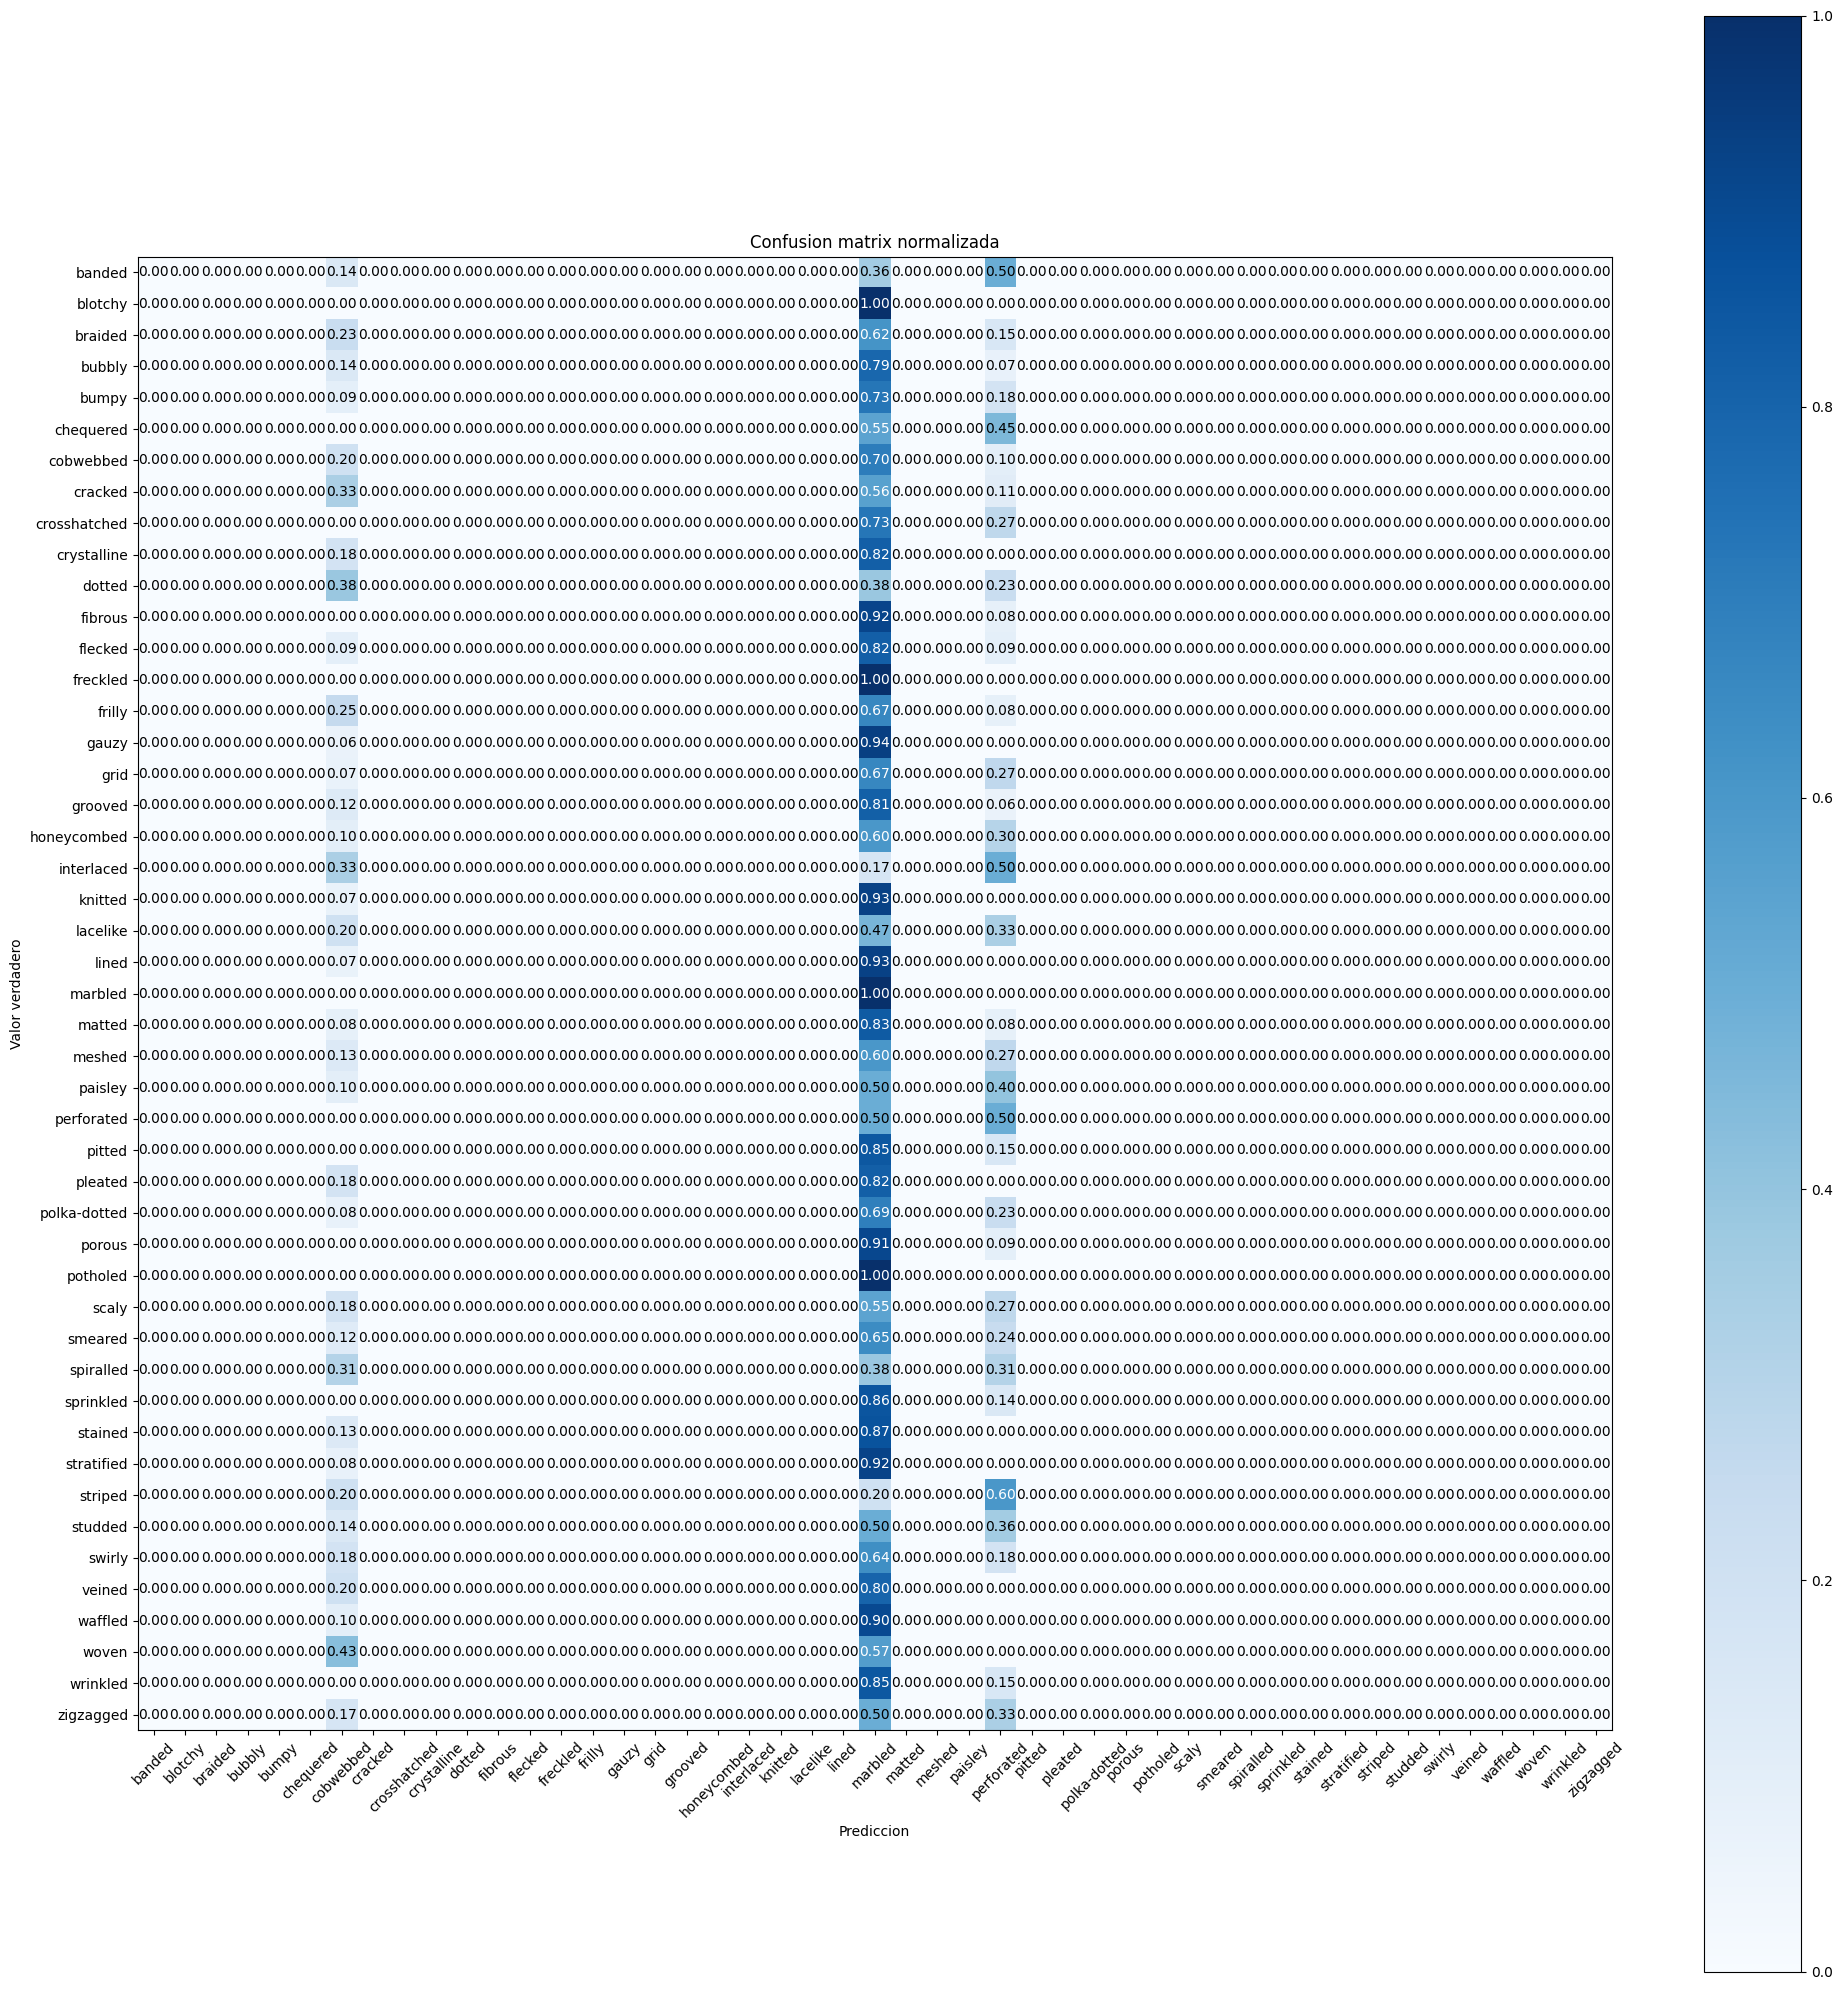

In [13]:
from sklearn.metrics import confusion_matrix

# Ploteo la confusion matrix para ver mas claramente los resultados
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Valor verdadero')
    plt.xlabel('Prediccion')
    plt.tight_layout()
    plt.show()
    
model.eval()
y_true = []
y_pred = []
for x, y in test_dataloader:
    prediction = model(x)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(prediction.argmax(1).cpu().numpy())
    
plot_confusion_matrix(y_true, y_pred, classes=dataset.classes,title='Confusion matrix normalizada')



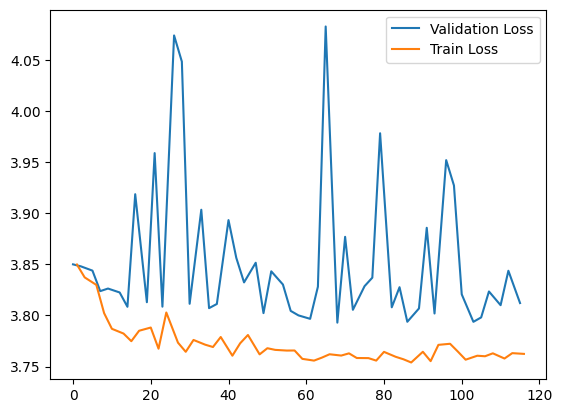

In [14]:
version_nr = 35

loss_file = pd.read_csv(f'lightning_logs/version_{version_nr}/metrics.csv')
plt.plot(loss_file['val_loss'].loc[~np.isnan(loss_file['val_loss'])] , label='Validation Loss')
plt.plot(loss_file['train_loss_epoch'].loc[~np.isnan(loss_file['train_loss_epoch'])], label='Train Loss')
plt.legend()
plt.show()

# Modelo MLP

In [20]:
subscaling = 256
transform = transforms.Compose([
    transforms.Resize((subscaling, subscaling)), # Redimensionar las imágenes al valor especificado en subscaling
    transforms.ToTensor(), # Convertir las imágenes a tensores y normalizar los valores de los pixeles a [0, 1]
    transforms.Lambda(lambda x: x.view(-1))

])

# Descargar y cargar el dataset
dataset = DTD(root='data', download=True, transform=transform)

# Dividir el dataset en train, validation y test
total_samples = len(dataset)
n_train_samples = int(0.55 * total_samples)
n_val_samples = int(0.15 * total_samples)
n_test_samples = total_samples - n_train_samples - n_val_samples
train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])


# Crear DataLoaders
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [21]:
# Probamos el modelo MLP

backbone2 = torch.nn.Sequential(
    torch.nn.Linear(3*subscaling*subscaling, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 47)
)
    
optimizer = torch.optim.Adam
optimizer_args = {'lr': 1e-3, 'weight_decay': 1e-5}
loss = torch.nn.CrossEntropyLoss()

model2 = BaseModel(backbone=backbone2,
                    optimizer=optimizer,
                    loss_fn=loss,
                    optimizer_args=optimizer_args)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
trainer_args = {
    'max_epochs': 200,
    'gpus': [0] if torch.cuda.is_available() else [],
    'callbacks': [early_stopping],
    'enable_progress_bar': True,
}
trainer2 = pl.Trainer(**trainer_args)
trainer2.fit(model2, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | Sequential       | 25.2 M
1 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
25.2 M    Trainable params
0         Non-trainable params
25.2 M    Total params
100.709   Total estimated model params size (MB)


/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it, loss=23, v_num=37, train_loss_step=23.40, val_loss=17.30]

Metric val_loss improved. New best score: 17.334


Epoch 1: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, loss=17.5, v_num=37, train_loss_step=9.690, val_loss=7.780, train_loss_epoch=22.90]

Metric val_loss improved by 9.550 >= min_delta = 0.0. New best score: 7.784


Epoch 2: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, loss=13.7, v_num=37, train_loss_step=4.860, val_loss=5.600, train_loss_epoch=12.50]

Metric val_loss improved by 2.185 >= min_delta = 0.0. New best score: 5.599


Epoch 3: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, loss=11.5, v_num=37, train_loss_step=3.930, val_loss=4.550, train_loss_epoch=6.460]

Metric val_loss improved by 1.045 >= min_delta = 0.0. New best score: 4.555


Epoch 4: 100%|██████████| 7/7 [00:09<00:00,  1.33s/it, loss=6.8, v_num=37, train_loss_step=3.740, val_loss=4.140, train_loss_epoch=5.160] 

Metric val_loss improved by 0.416 >= min_delta = 0.0. New best score: 4.139


Epoch 5: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it, loss=4.81, v_num=37, train_loss_step=3.910, val_loss=4.020, train_loss_epoch=4.250]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 4.022


Epoch 6: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it, loss=4.25, v_num=37, train_loss_step=3.800, val_loss=3.970, train_loss_epoch=4.020]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 3.975


Epoch 7: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it, loss=3.98, v_num=37, train_loss_step=3.810, val_loss=3.920, train_loss_epoch=3.940]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 3.916


Epoch 8: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it, loss=3.91, v_num=37, train_loss_step=3.950, val_loss=3.900, train_loss_epoch=3.870]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 3.899


Epoch 10: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it, loss=3.86, v_num=37, train_loss_step=3.960, val_loss=3.890, train_loss_epoch=3.820]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 3.891


Epoch 17: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it, loss=3.81, v_num=37, train_loss_step=3.870, val_loss=3.880, train_loss_epoch=3.800]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 3.878


Epoch 33: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it, loss=3.85, v_num=37, train_loss_step=3.840, val_loss=3.850, train_loss_epoch=3.850]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 3.853


Epoch 41: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it, loss=3.82, v_num=37, train_loss_step=3.820, val_loss=3.850, train_loss_epoch=3.840]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 3.852


Epoch 61: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it, loss=3.85, v_num=37, train_loss_step=3.840, val_loss=3.860, train_loss_epoch=3.850]

Monitored metric val_loss did not improve in the last 20 records. Best score: 3.852. Signaling Trainer to stop.


Epoch 61: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it, loss=3.85, v_num=37, train_loss_step=3.840, val_loss=3.860, train_loss_epoch=3.850]


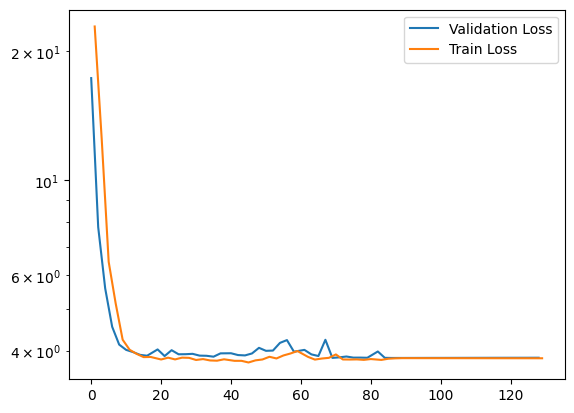

In [24]:
# Visualizar el entrenamiento

version_nr = 37

loss_file = pd.read_csv(f'lightning_logs/version_{version_nr}/metrics.csv')
plt.plot(loss_file['val_loss'].loc[~np.isnan(loss_file['val_loss'])] , label='Validation Loss')
plt.plot(loss_file['train_loss_epoch'].loc[~np.isnan(loss_file['train_loss_epoch'])], label='Train Loss')
plt.legend()
plt.yscale('log')
plt.show()


In [25]:
# Guardar el modelo entrenado
#torch.save(model2.state_dict(), 'linear_1.pth')

ckpt = torch.load('./linear_1.pth')
model2.load_state_dict(ckpt)


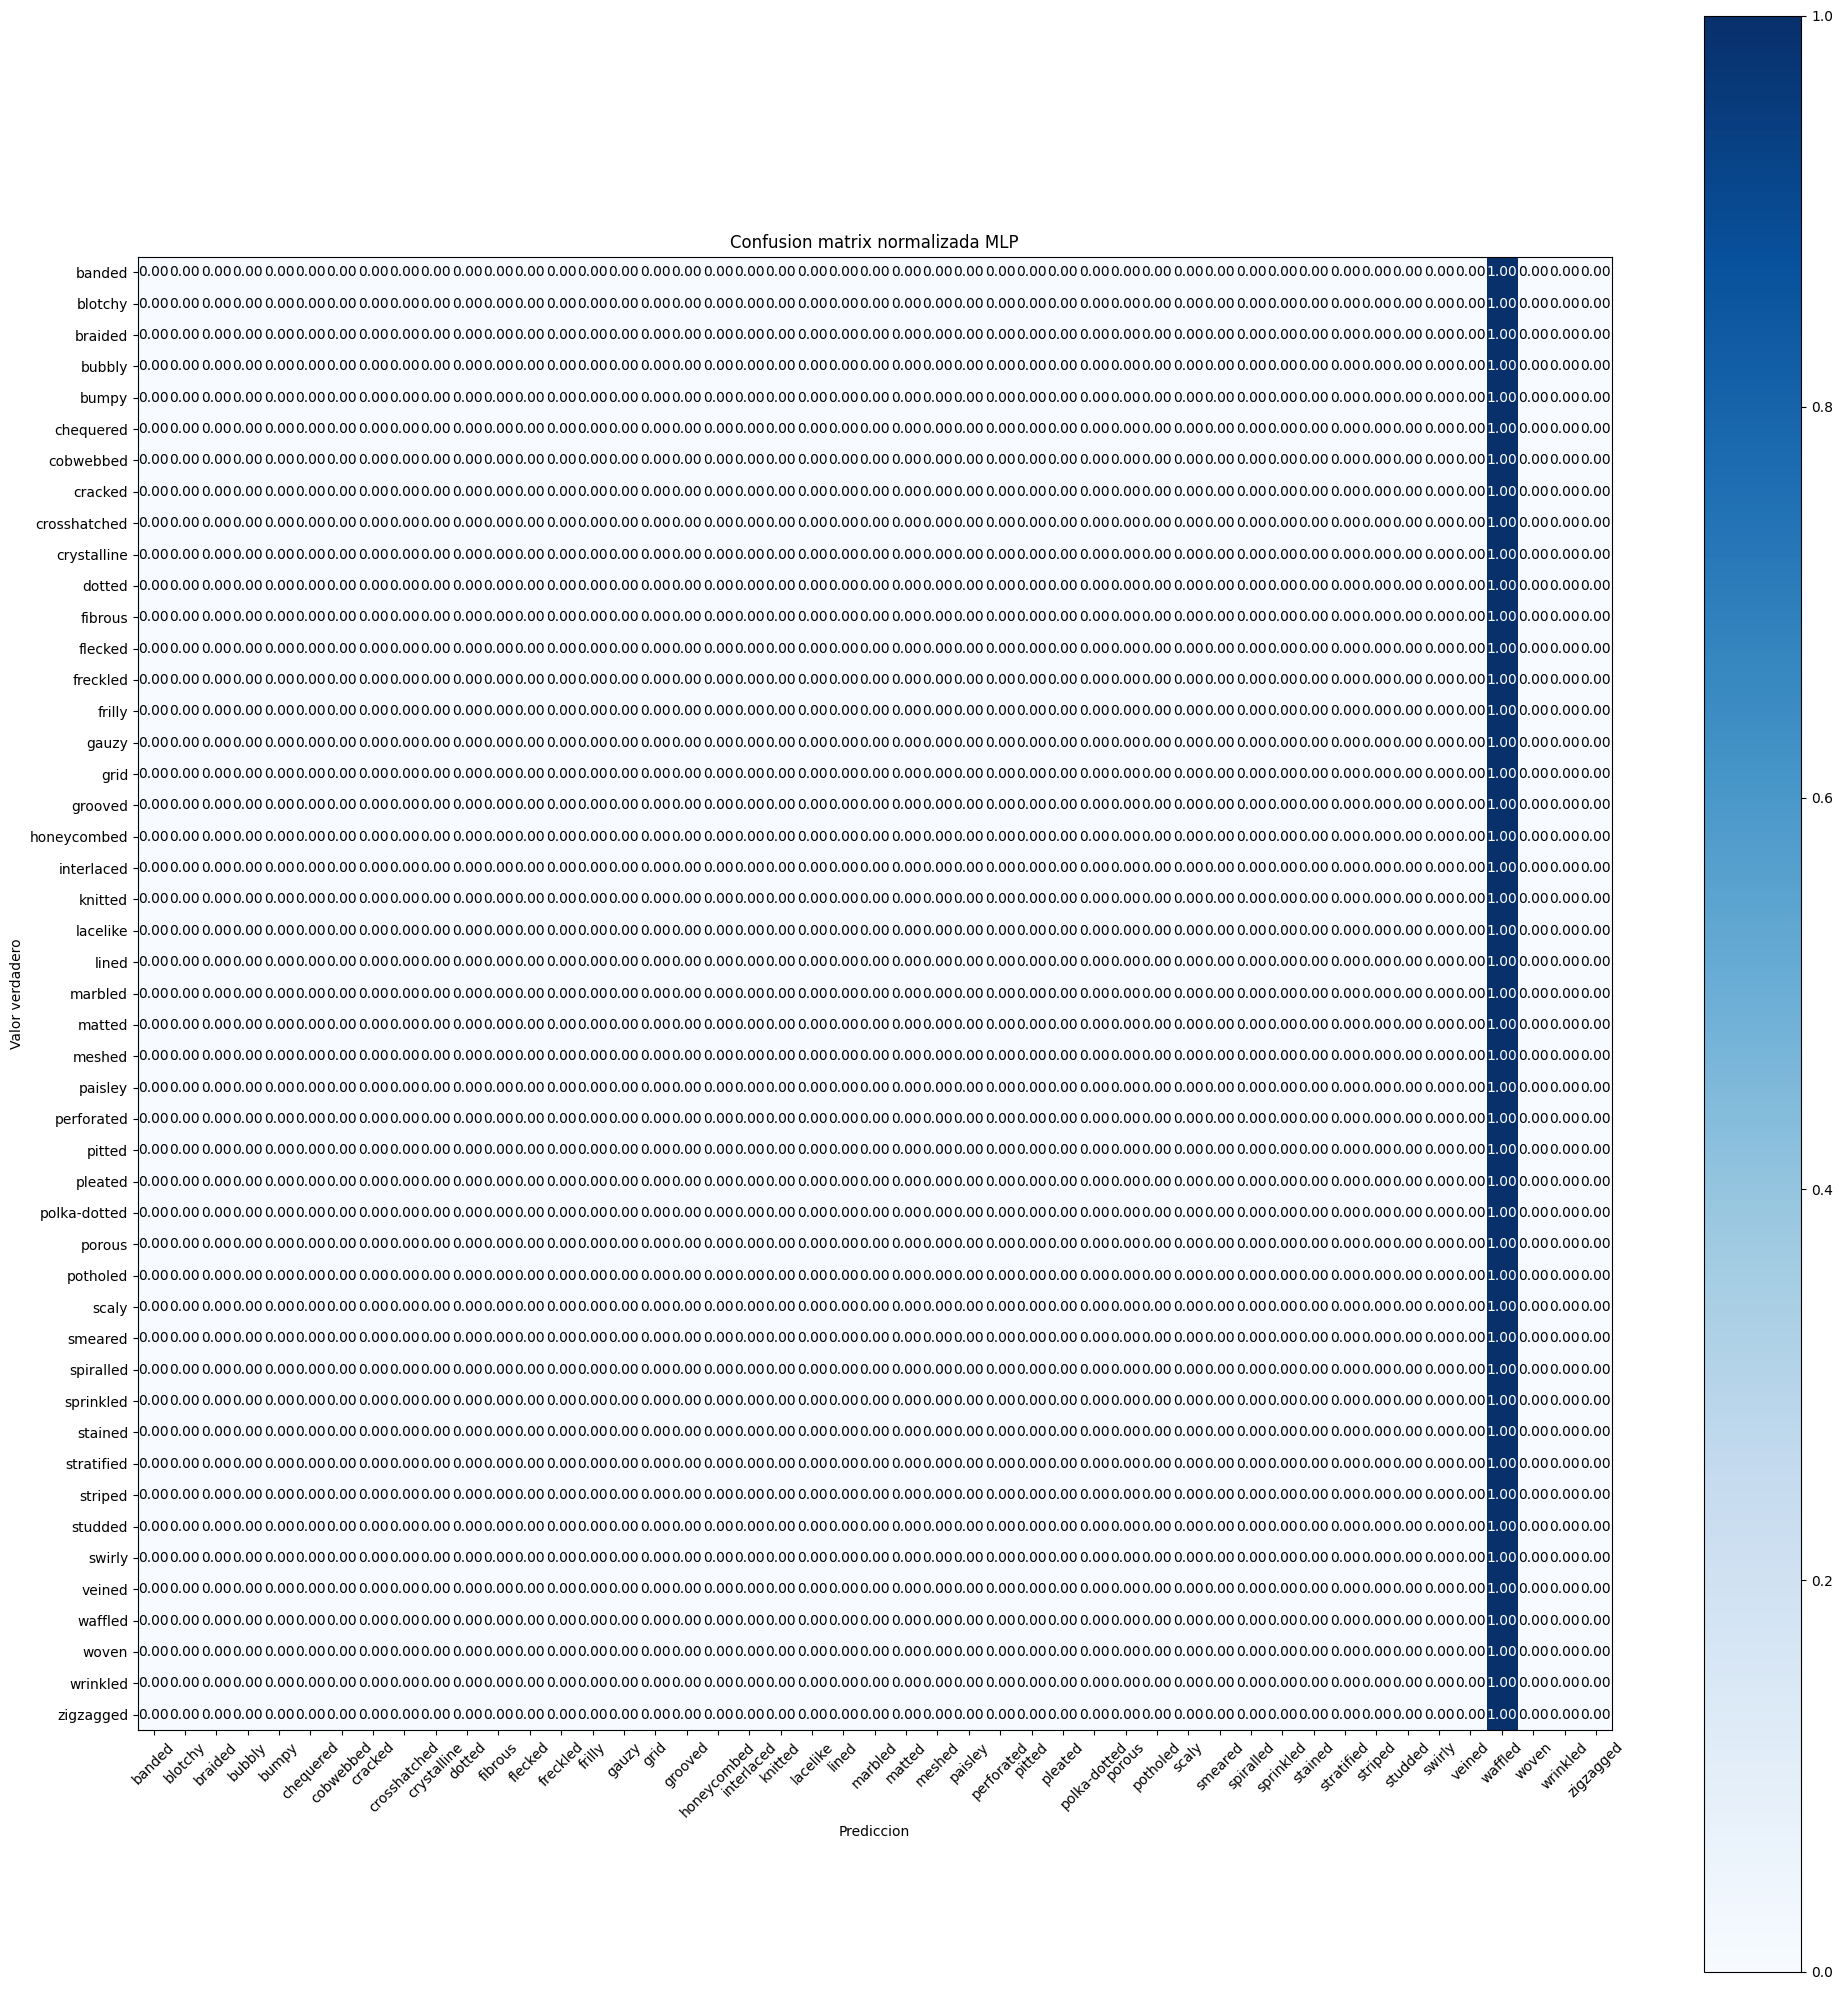

In [26]:
model2.eval()
y_true = []
y_pred = []
for x, y in test_dataloader:
    prediction = model2(x)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(prediction.argmax(1).cpu().numpy())
    
plot_confusion_matrix(y_true, y_pred, classes=dataset.classes,title='Confusion matrix normalizada MLP')

Parece que ninguno de los modelos ha funcionado como se esperaba.
De todas formas las weights han sido guardadas y el script para produccion listo.